# **Loading Packages**
Make sure to install the packages before trying to load them if they're not already installed.

In [3]:
library(DESeq2)
library(edgeR)

# **Data Loading**

In [2]:
# Loading the pseudo-bulk file from  that we generated in Python 
pb <- read.csv("pseudobulk_matrix.csv")

meta <- read.csv("meta_matrix.csv")

# **Defining counts and phenotype (meta)**

In [4]:

# Separate the expression from the metadata
counts <- pb[, !(colnames(pb) %in% 
                   c("class", "donor_id", "disease", "sex"))]

counts <- t(as.matrix(counts))

# rownames(expr) <- paste(pb$class, pb$donor_id, pb$disease, sep="_")

In [5]:
meta <- data.frame(
  class = pb$class,
  donor = pb$donor_id,
  disease = factor(pb$disease,levels = c("dementia || Alzheimer disease", "dementia || Parkinson disease" ,"normal")),
  sex = pb$sex
)

In [6]:
head(counts)

ENSG00000000003,71,63,110,19,60,30,104,131,52,54,⋯,1,30,0,17,13,5,0,10,8,1
ENSG00000000005,7,1,12,3,6,4,2,3,3,2,⋯,0,3,0,0,0,0,0,0,1,0
ENSG00000000419,242,258,140,154,245,107,229,257,58,76,⋯,134,1038,155,907,927,293,15,319,808,55
ENSG00000000457,173,197,102,112,156,73,146,183,29,54,⋯,85,745,146,335,605,204,11,213,516,38
ENSG00000000460,139,123,101,69,106,56,144,65,36,66,⋯,78,820,203,577,625,266,15,165,642,35
ENSG00000000938,1,2,1,1,2,2,4,4,1,3,⋯,2,4,2,4,9,6,0,4,5,0


In [7]:
# Checking the dimensions
cat("genes:", nrow(counts), "\n")
cat("samples:", ncol(counts), "\n")
cat("meta rows:", nrow(meta), "\n")

genes: 34167 
samples: 136 
meta rows: 136 


# **DEG Analysis with edgeR**

In [ ]:
for (ct in unique(meta$class)) {
  idx <- meta$class == ct
  cts  <- counts[, idx, drop = FALSE]
  pheno <- meta[idx, , drop = FALSE]

  # Part 1: edgeR
  y <- DGEList(counts = cts, samples = pheno) 

  # 1. Normalization (TMM = Trimmed Mean of M-values)
  y <- calcNormFactors(y, method = "TMM")

  # 2. Creation of the design matrix
  design <- model.matrix(~ 0 + disease + sex, data = pheno)
  colnames(design)[1:3] <- c("AD", "PD", "CTRL") # in the same order than in meta

  # 3. Filtering out low-expressed genes: this deletes the genes with a lot of zeros, reducing the noise and enhancing statistical power
  keep <- filterByExpr(y, design = design)
  y <- y[keep, , keep.lib.sizes = FALSE]


  # 4. Estimation of the 3 dispersions:
  # a. shared dispersion (global), b. trended dispersion (depends on expression levels), c. tagwise dispersion (per gene)
  y <- estimateDisp(y, design)

  # 5. Fitting of the GLM model (QLF)
  fit <- glmQLFit(y, design)

  # Part 2 : Multiple Comparisons
  cont <- makeContrasts(
    AD_vs_CTRL = AD - CTRL,
    PD_vs_CTRL = PD - CTRL,
    AD_vs_PD   = AD - PD,
    levels = design
  )

  ### Part 3 : Making and saving the comparisons
  for (cn in colnames(cont)) {

    qlf <- glmQLFTest(fit, contrast = cont[,cn])
    tab <- topTags(qlf, n = Inf)$table

    out <- paste0("edgeR_results/edgeR_", ct, "_", cn, ".csv")
    write.csv(tab, file = out, row.names = TRUE)
  }
}

Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: generics


Attaching package: ‘generics’


The following objects are masked from ‘package:base’:

    as.difftime, as.factor, as.ordered, intersect, is.element, setdiff,
    setequal, union



Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, saveRDS, table, tapply, unique,
    unsplit, which.max, which.min



Attaching package: ‘S4Vectors’


The following object is masked from ‘package:utils’:

    findMatches


The follo

ERROR: Error in h(simpleError(msg, call)): error in evaluating the argument 'x' in selecting a method for function 'unique': object 'meta' not found


##### Verification of direction of differential analysis

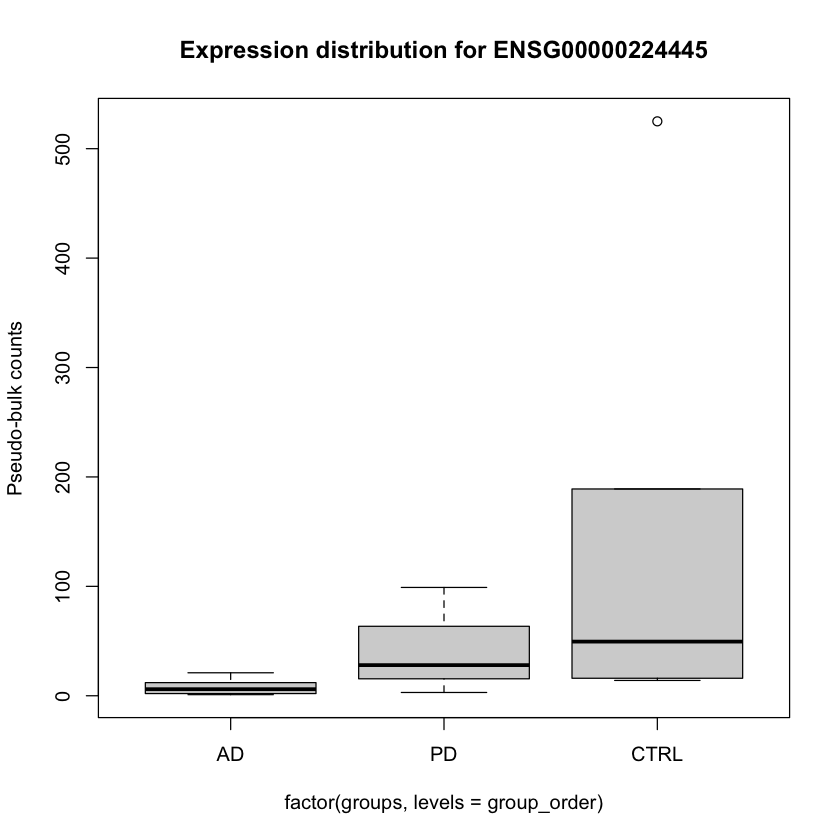

In [55]:
gene <- "ENSG00000224445"   # gène à visualiser

expr <- cts[gene, ]               # vecteur d'expression pseudo-bulk
groups <- pheno$disease           # groupes AD / PD / CTRL

# Ordre pour que ça corresponde exactement à Python
group_order <- c("dementia || Alzheimer disease",
                 "dementia || Parkinson disease",
                 "normal")

boxplot(expr ~ factor(groups, levels = group_order),
        names = c("AD", "PD", "CTRL"),
        ylab = "Pseudo-bulk counts",
        main = paste("Expression distribution for", gene))


##### Visualization of results

*Example 1* 

In [56]:
res <- read.csv("edgeR_results/edgeR_Immune_AD_vs_CTRL.csv", row.names = 1)

In [57]:
head(res)

,logFC,logCPM,F,PValue,FDR
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000224445,-3.332923,3.201687,20.18698,0.0001456244,0.9899694
ENSG00000286251,-2.841352,2.608657,18.13103,0.0002430557,0.9899694
ENSG00000126838,-3.251837,3.120778,17.98941,0.0002655522,0.9899694
ENSG00000257252,-1.593996,3.462496,17.46406,0.0004657406,0.9899694
ENSG00000259543,-1.158222,3.820907,17.99442,0.0004721311,0.9899694
ENSG00000253184,4.862826,4.864369,16.45253,0.0005243205,0.9899694


In [58]:
length(unique(res$FDR)) 

[1] 111

In [59]:
summary(res$FDR)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.9900  0.9900  0.9900  0.9922  0.9947  1.0000 

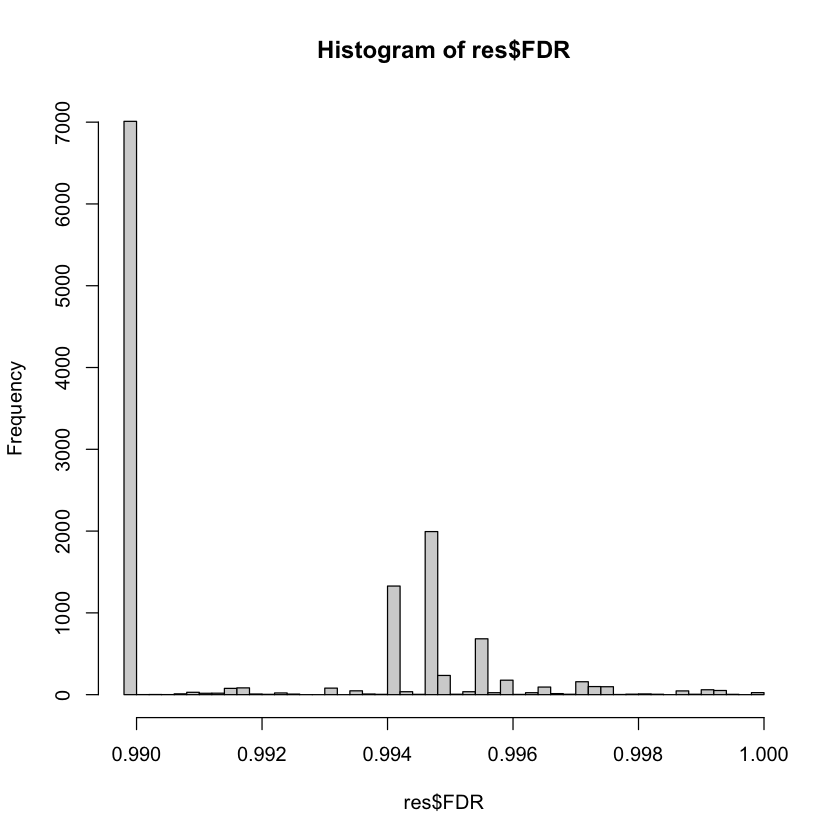

In [60]:
hist(res$FDR, breaks = 50)

*Example 2*

In [61]:
res <- read.csv("edgeR_results/edgeR_Immune_PD_vs_CTRL.csv", row.names = 1)

In [62]:
head(res)

,logFC,logCPM,F,PValue,FDR
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000267698,-2.5539724,3.585942,31.55400,1.593422e-05,0.2016316
ENSG00000153982,-1.7875841,4.629218,29.15432,4.143747e-05,0.2621749
ENSG00000083635,1.2057023,4.110487,20.11782,2.997575e-04,0.6378880
ENSG00000112874,-1.9359442,3.856194,18.28791,4.086840e-04,0.6378880
ENSG00000173482,0.9732204,7.466944,17.80002,5.301722e-04,0.6378880
ENSG00000175426,-2.5123825,3.425452,16.49139,5.623918e-04,0.6378880


In [63]:
length(unique(res$FDR)) 

[1] 2077

In [64]:
summary(res$FDR)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.2016  0.7416  0.8369  0.8276  0.9225  1.0000 

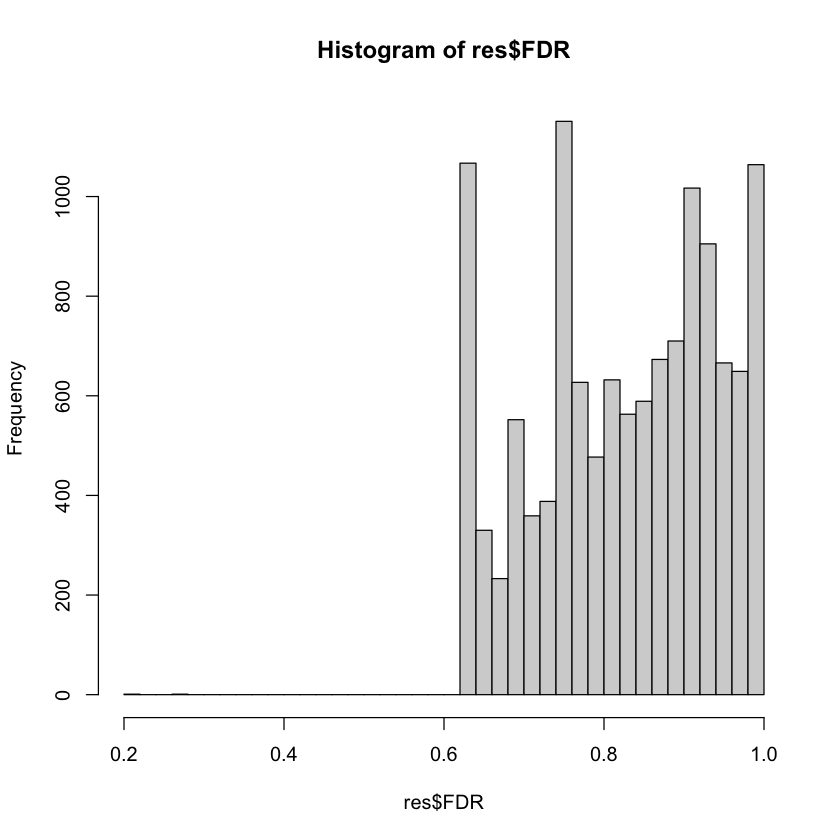

In [65]:
hist(res$FDR, breaks = 50)

Format : 

- y$counts     = matrix (genes × samples)

- y$samples    = data.frame (samples × covariates)

# **DEG Analysis with DESeq2** 

Should we keep this? 

Maybe need to re-run the defining counts and meta

In [8]:
library(DESeq2)

for (ct in unique(meta$class)) {

  idx <- meta$class == ct
  cts  <- counts[, idx, drop = FALSE]
  pheno <- meta[idx, , drop = FALSE]

  # facteurs
  pheno$disease <- factor(
    pheno$disease,
    levels = c("normal", 
               "dementia || Alzheimer disease",
               "dementia || Parkinson disease")
  )
  pheno$sex <- factor(pheno$sex)

  # Création objet DESeq2
  dds <- DESeqDataSetFromMatrix(
    countData = cts,
    colData   = pheno,
    design    = ~ disease + sex
  )

  # Filtrage des gènes très faibles (équivalent filterByExpr edgeR)
  keep <- rowSums(counts(dds)) >= 10
  dds <- dds[keep, ]

  # Normalisation + estimation des dispersions + fitting
  dds <- DESeq(dds)

  # CONTRASTS
  # Référence = "normal" (CTRL)

  # AD vs CTRL
  res_AD <- results(dds, contrast = c("disease",
                                      "dementia || Alzheimer disease",
                                      "normal"))

  # PD vs CTRL
  res_PD <- results(dds, contrast = c("disease",
                                      "dementia || Parkinson disease",
                                      "normal"))

  # AD vs PD
  res_AD_PD <- results(dds, contrast = c("disease",
                                         "dementia || Alzheimer disease",
                                         "dementia || Parkinson disease"))

  # Export
  write.csv(as.data.frame(res_AD),
            paste0("DESeq2_results/DESeq2_", ct, "_AD_vs_CTRL.csv"))
  write.csv(as.data.frame(res_PD),
            paste0("DESeq2_results/DESeq2_", ct, "_PD_vs_CTRL.csv"))
  write.csv(as.data.frame(res_AD_PD),
            paste0("DESeq2_results/DESeq2_", ct, "_AD_vs_PD.csv"))
}

converting counts to integer mode

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

estimating size factors

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R.

Visualization of results

*Example*

In [ ]:
df <- read.csv("DESeq2_results/DE_IN_ADvsPD.csv", row.names = 1)
head(df)

In [ ]:
summary(df$padj)

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000000003,7.618874,-0.235953345,0.5166267,-0.456719212,0.6478729,1
ENSG00000000005,1.277961,1.064173276,1.4979016,0.710442705,0.4774296,1
ENSG00000000419,210.721631,0.001008416,0.1612832,0.006252452,0.9950113,1
ENSG00000000457,113.876740,-0.272815484,0.1785876,-1.527628723,0.1266047,1
ENSG00000000460,96.303641,0.127990125,0.2969305,0.431044015,0.6664364,1
ENSG00000000938,1.624470,-0.200112617,1.1556028,-0.173167299,0.8625199,1


    Min.  1st Qu.   Median     Mean  3rd Qu.     Max.     NA's 
0.000011 1.000000 1.000000 0.999821 1.000000 1.000000      161 

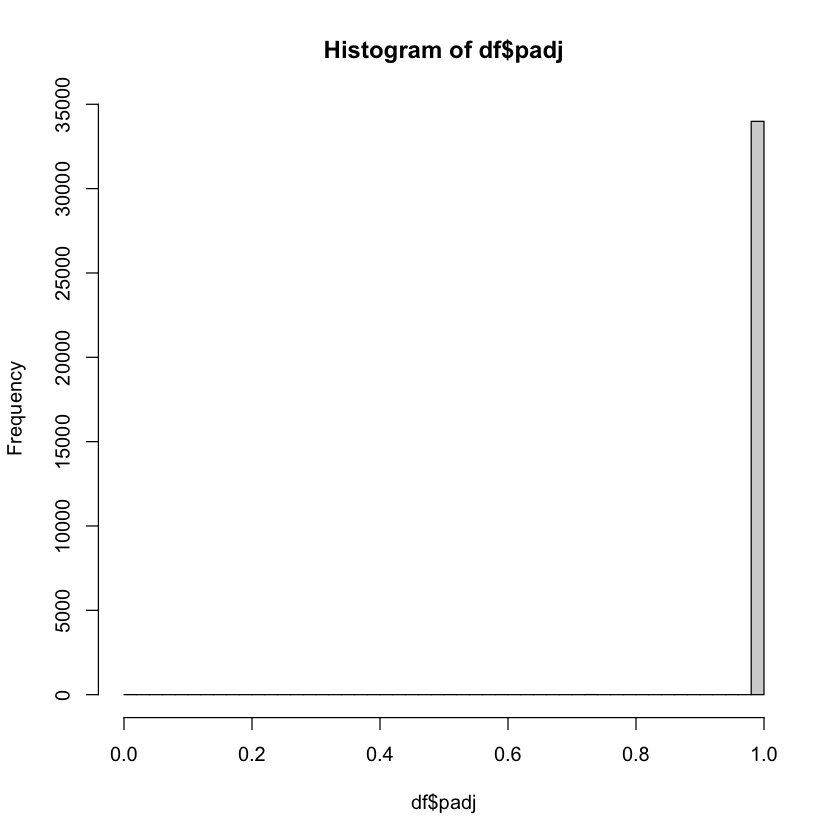

In [ ]:
hist(df$padj, breaks = 50)

# **Comparision of edgeR and DESeq2**

In [9]:
edgeR <- read.csv("edgeR_results/edgeR_Astro_AD_vs_CTRL.csv", row.names = 1)
deseq <- read.csv("DESeq2_results/DESeq2_Astro_AD_vs_CTRL.csv", row.names = 1)

In [ ]:
# rename columns
colnames(edgeR)[colnames(edgeR) == "logFC"] <- "logFC_edgeR"
colnames(edgeR)[colnames(edgeR) == "PValue"] <- "p_edgeR"
colnames(edgeR)[colnames(edgeR) == "FDR"] <- "padj_edgeR"

colnames(deseq)[colnames(deseq) == "log2FoldChange"] <- "logFC_deseq"
colnames(deseq)[colnames(deseq) == "pvalue"] <- "p_deseq"
colnames(deseq)[colnames(deseq) == "padj"] <- "padj_deseq"

In [11]:
merged <- merge(edgeR, deseq,
                by = "row.names",
                all = TRUE)
colnames(merged)[1] <- "gene"

correlations between edgeR and DESeq2

In [22]:
cat("correlation between logFC :", cor(merged$logFC_edgeR, merged$logFC_deseq, use = "complete.obs"),"\n")
cat("correlation between p-values :", cor(merged$p_edgeR, merged$p_deseq, use = "complete.obs"),"\n")
cat("correlation between adjusted p-values :", cor(merged$padj_edgeR, merged$padj_deseq, use = "complete.obs"),"\n")

correlation between logFC : 0.9907504 
correlation between p-values : 0.9366783 
correlation between adjusted p-values : 0.9260183 


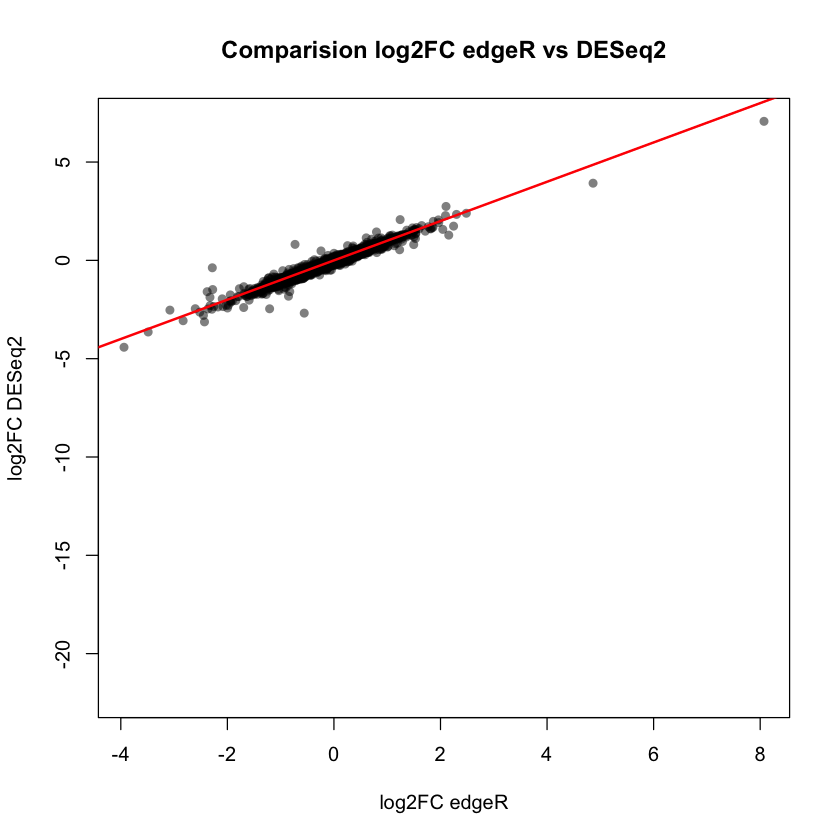

In [23]:
plot(merged$logFC_edgeR, merged$logFC_deseq,
     xlab = "log2FC edgeR",
     ylab = "log2FC DESeq2",
     main = "Comparision log2FC edgeR vs DESeq2",
     pch = 16, col = rgb(0,0,0,0.5))
abline(0, 1, col = "red", lwd = 2)